Part 0: Feature Generation

In [24]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import featuretools as ft
import businesstime
import datetime
import warnings
import time
import os
from sklearn.exceptions import DataConversionWarning
from subprocess import check_output
from pandas.plotting import scatter_matrix
from businesstime.holidays.usa import USFederalHolidays
from sklearn import preprocessing
import ipdb 
ipdb.set_trace()
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
"""
" HyperParams
"""
generateDataFlag = True
generateFeaturesFlag = True
windowSizeGrid = [2,3,4,5,6,7,8,9,10,15,30,60]
windowSize = windowSizeGrid[0]

def dataGen(data):
    if 'FLAG_BusinessHour' not in data.columns:
        bt = businesstime.BusinessTime(business_hours = (datetime.time(9), datetime.time(18)),\
                                       weekends=(5, 6), holidays=USFederalHolidays())
        dates, isBD = [],[]
        for row in data.itertuples(index=True, name='Pandas'):
            dates.append(getattr(row, "date"))
        for row in dates:
            boo = bt.isduringbusinesshours(datetime.datetime.strptime(row, '%Y-%m-%d %H:%M:%S'))
            isBD.append(1) if boo else isBD.append(0)
        data.insert(0, "FLAG_BusinessHour", isBD, True)
        data['GRAD_CO2'] = np.clip(np.gradient(data['CO2'].rolling(window=windowSize).mean()),-10,10)
        data['GRAD_HR'] = np.clip(np.gradient(data['HumidityRatio'].rolling(window=windowSize).mean()),-10,10)
        data['HRCO2'] = data['HumidityRatio']*data['CO2']
        data['GRAD_HRCO2'] = np.clip(np.gradient(data['HRCO2'].rolling(window=windowSize).mean()),-10,10)
        data['index'] = data.index
        data.drop("Occupancy", axis=1, inplace=True)
    return data

def entitySet(data):
    es = ft.EntitySet('sensor')
    es = es.entity_from_dataframe(index='index', entity_id='log', \
                                  dataframe = data, \
                                  variable_types={f: ft.variable_types.Categorical 
                                                  for f in data.columns if f.startswith('FLAG_')
                                                 })
    return es

def featureGen(data):
    es = entitySet(data)
    fm, feature_defs = ft.dfs(
        entityset=es, 
        target_entity='log', 
        #features_only=True,
        trans_primitives=['hour', 'day', 'weekday', 'percentile'],
        verbose=True,
        #training_window="12 hours"
    )
    fm['RMEAN_CO2'] = data['CO2'].rolling(window=windowSize).mean()
    fm['RMEAN_HR'] = data['HumidityRatio'].rolling(window=windowSize).mean()
    fm.fillna(method='bfill', inplace=True)
    return fm

for windowSize in windowSizeGrid:
    dataReady = True if os.path.isfile('../output/trainingWS' + str(windowSize) + '.csv') else False

    if dataReady:
        fm_train = pd.read_csv('../output/trainingWS' + str(windowSize) + '.csv')
        fm_test = pd.read_csv('../output/testWS' + str(windowSize) + '.csv')
        fm_test2 = pd.read_csv('../output/test2WS' + str(windowSize) + '.csv')
        data_y = pd.read_csv('../output/trainingTarget.csv')['Occupancy']
        vald_y = pd.read_csv('../output/testTarget.csv')['Occupancy']
        test_y = pd.read_csv('../output/test2Target.csv')['Occupancy']
    else:
        data = pd.read_csv('../input/datatraining.txt')
        val = pd.read_csv('../input/datatest.txt')
        test = pd.read_csv('../input/datatest2.txt')
        data_y = data['Occupancy']
        vald_y = val['Occupancy']
        test_y = test['Occupancy']

        if generateDataFlag:
            data_x = dataGen(data)
            vald_x = dataGen(val)
            test_x = dataGen(test)
        else:
            data_x = data
            vald_x = val
            test_x = test

        if generateFeaturesFlag:
            fm_train = featureGen(data_x).drop(['Humidity'],axis=1)
            fm_test  = featureGen(vald_x).drop(['Humidity'],axis=1)
            fm_test2 = featureGen(test_x).drop(['Humidity'],axis=1)
        else:
            fm_train = data_x.drop(['date','time','index','Humidity'],axis=1)
            fm_test  = vald_x.drop(['date','time','index','Humidity'],axis=1)
            fm_test2 = test_x.drop(['date','time','index','Humidity'],axis=1)

        fm_train = fm_train.drop(data.index[3830:3834]) # light anomaly detected, drop rows
        data_y = data_y.drop(data.index[3830:3834]) # light anomaly detected, drop rows
        
        fm_train.to_csv('../output/trainingWS' + str(windowSize) + '.csv', index=False)
        fm_test.to_csv('../output/testWS' + str(windowSize) + '.csv', index=False)
        fm_test2.to_csv('../output/test2WS' + str(windowSize) + '.csv', index=False)
        data_y.to_csv('../output/trainingTarget.csv', index=False, header='Occupancy')
        vald_y.to_csv('../output/testTarget.csv', index=False, header='Occupancy')
        test_y.to_csv('../output/test2Target.csv', index=False, header='Occupancy')

--Return--
None
> <ipython-input-24-47801e4565d5>(17)<module>()
     16 import ipdb
---> 17 ipdb.set_trace()
     18 warnings.filterwarnings(action='ignore', category=DataConversionWarning)

ipdb> c
Built 22 features
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks
Built 22 features
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks
Built 22 features
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks
Built 22 features
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks
Built 22 features
Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks
Built 22 features
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks
Built 22 features
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks
Built 22 features
Elapsed: 00:00 | Remaining: 00:00 | Progr

Part I: Data Visualisation

Number of Occupied:  1729
Number of Empty:  6410


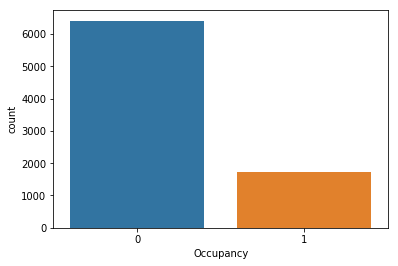

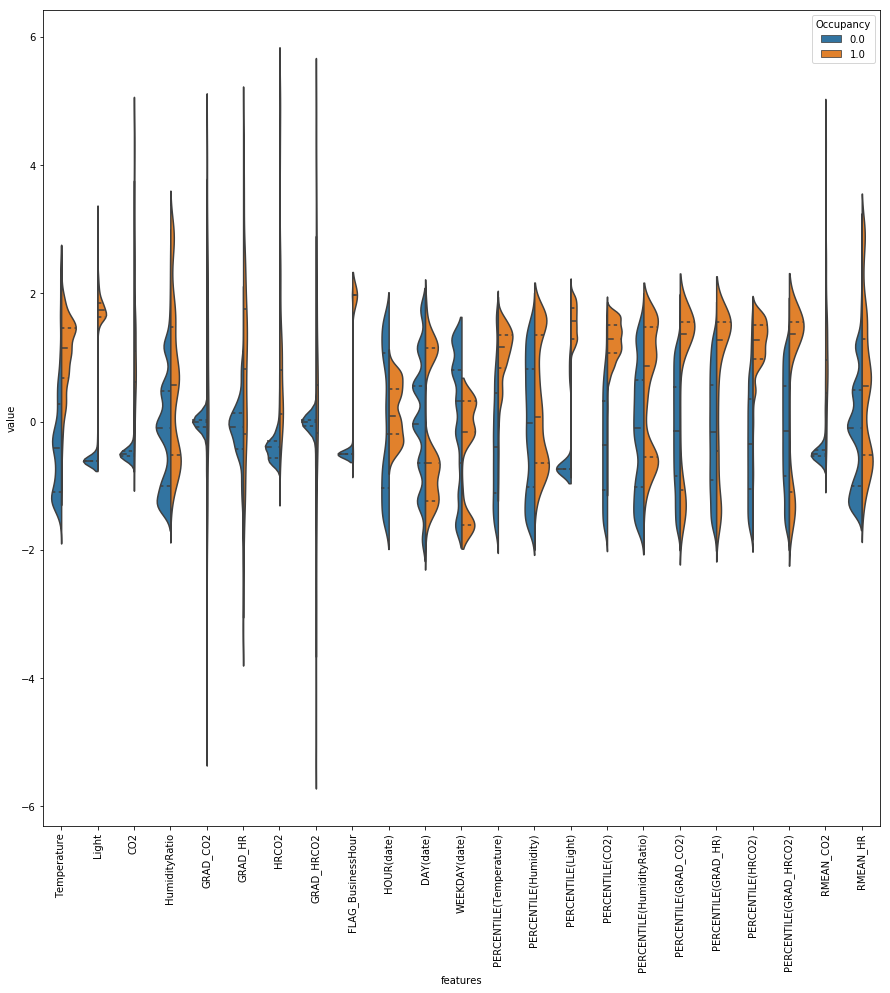

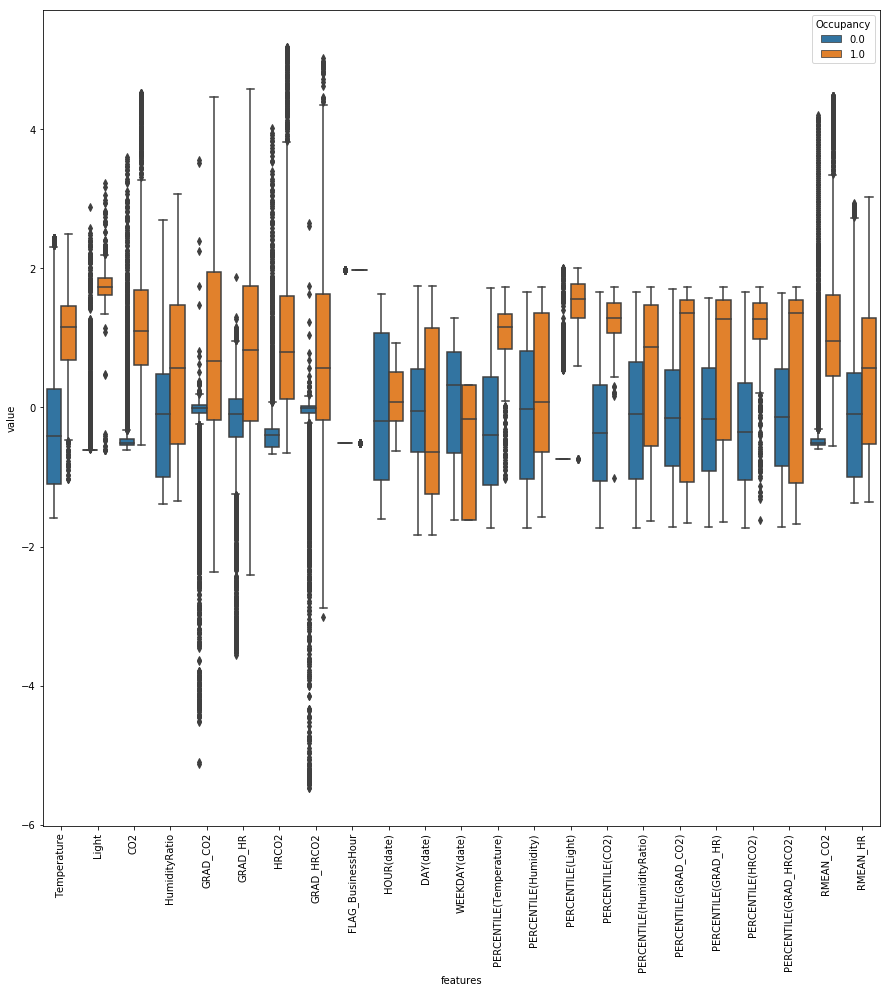

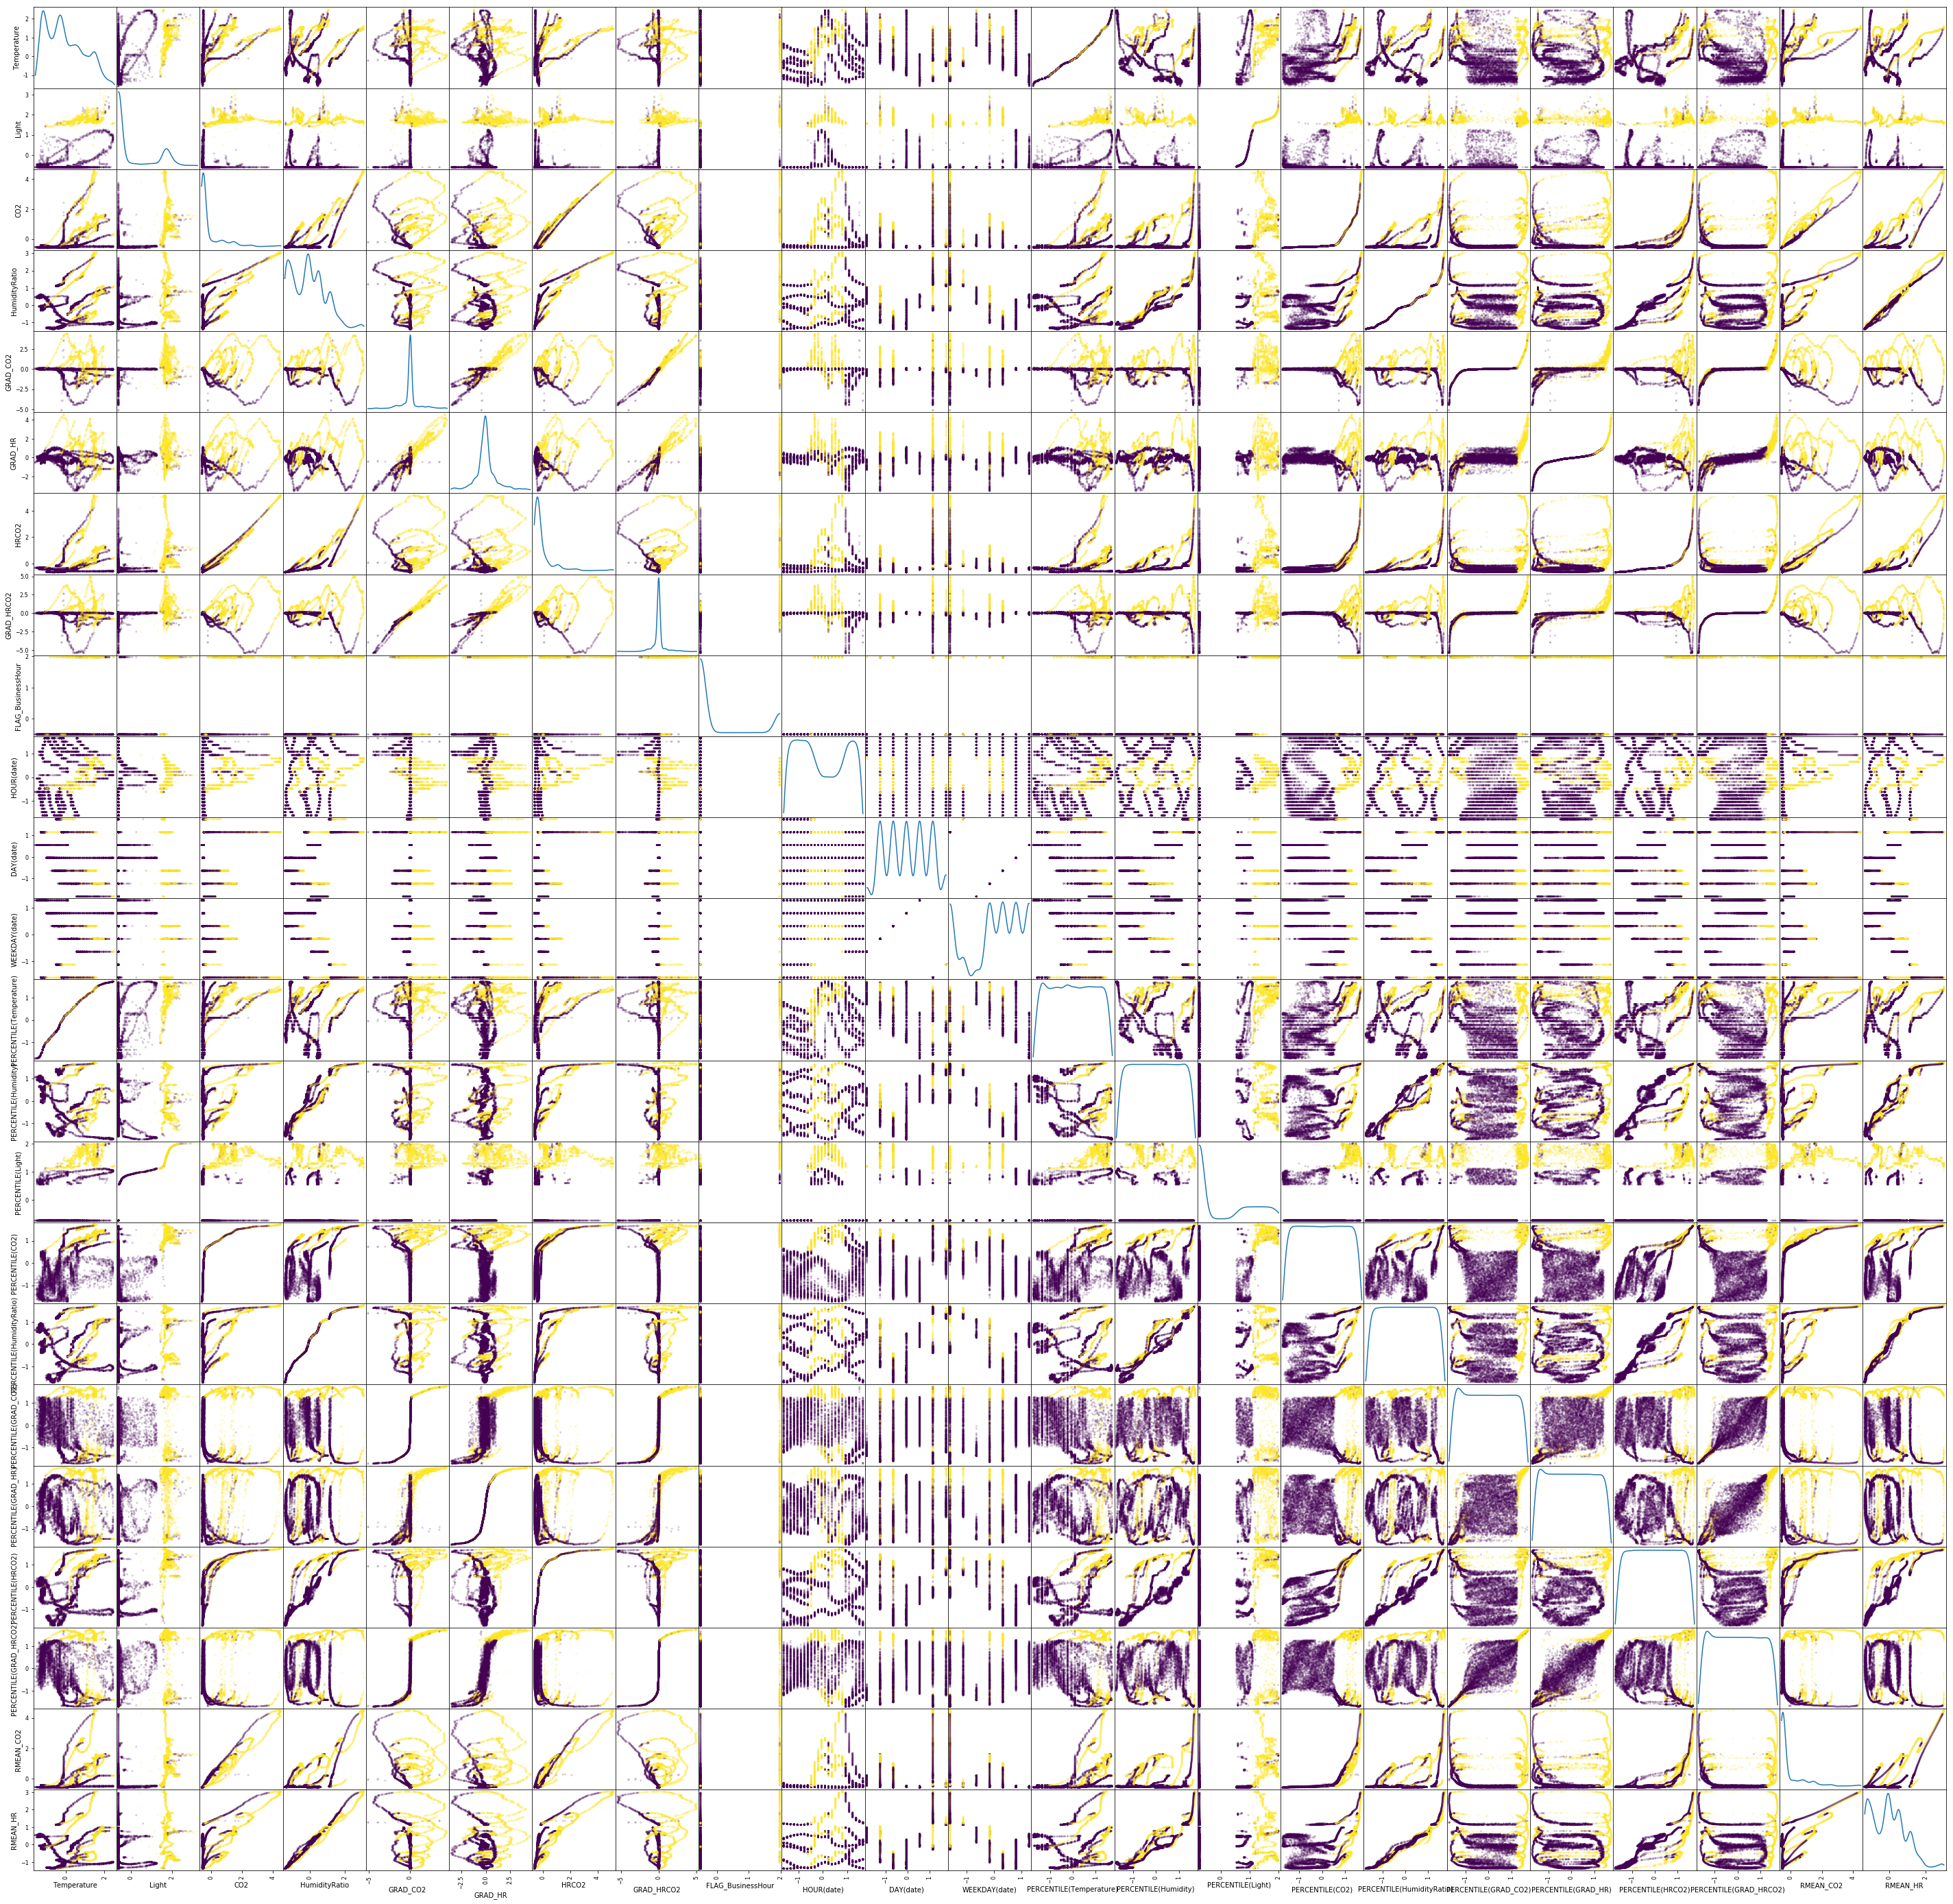

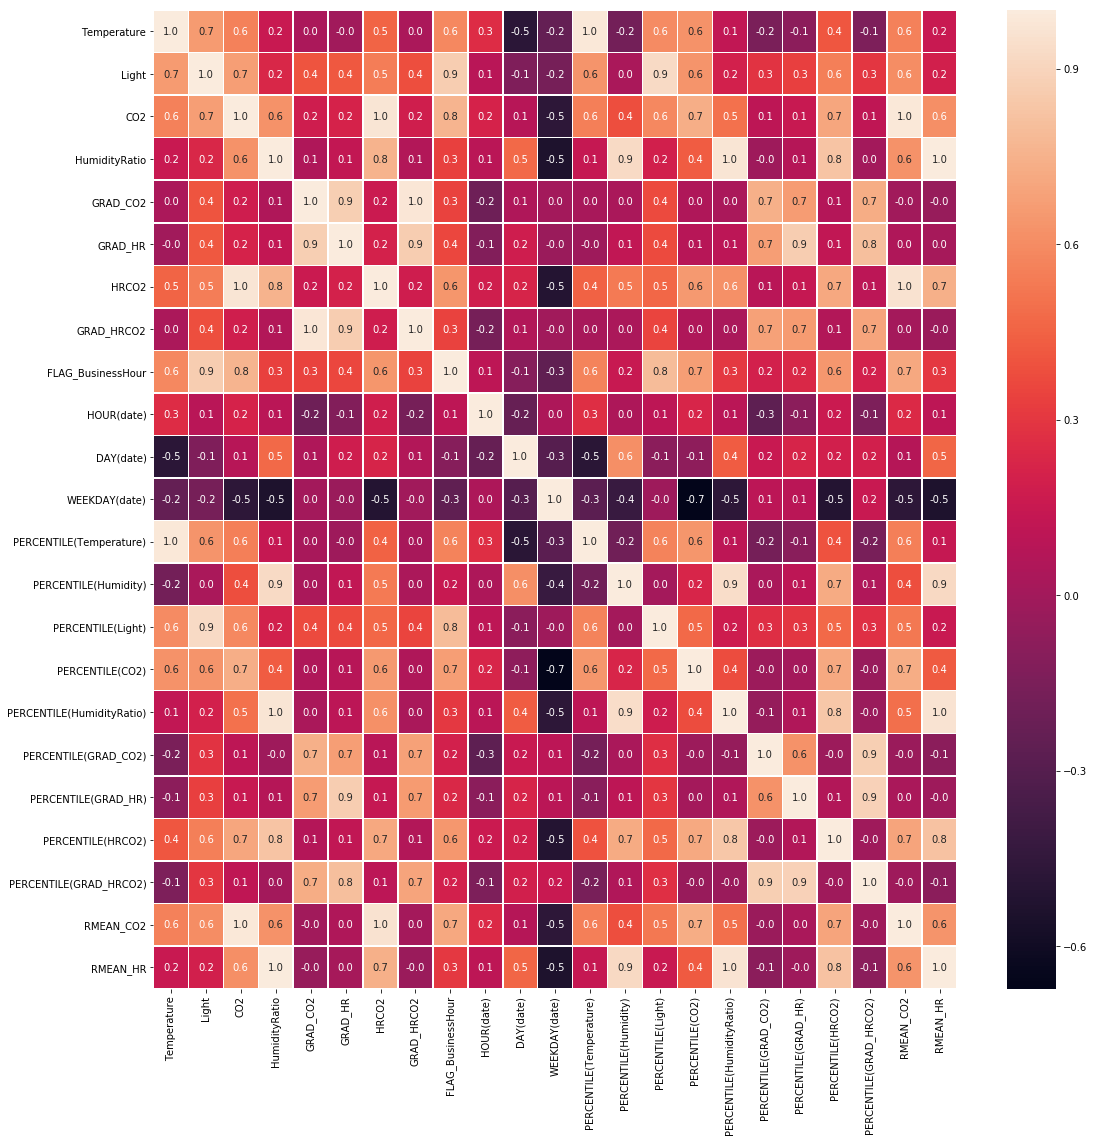

In [25]:
ax = sns.countplot(data_y,label="Count")
E, O = data_y.value_counts()
print('Number of Occupied: ', O)
print('Number of Empty: ', E)
plt.figure(figsize=(15,15)) # labels are badly skewed, need stratified sampling

stdscaler = preprocessing.StandardScaler()
minmaxscaler = preprocessing.MinMaxScaler()
data_n_2 = pd.DataFrame(stdscaler.fit_transform(fm_train), columns=fm_train.columns)
data = pd.concat([data_y,data_n_2],axis=1)
data = pd.melt(data,id_vars="Occupancy",
                    var_name="features",
                    value_name='value')
sns.violinplot(x="features", y="value", hue="Occupancy", data=data,split=True, inner="quart")
plt.xticks(rotation=90)
plt.figure(figsize=(15,15))
sns.boxplot(x="features", y="value", hue="Occupancy", data=data)
plt.xticks(rotation=90)

scatter_matrix(data_n_2, c=data_y, alpha=0.2, figsize=(50,50), diagonal='density')
fig = plt.gcf()
fig.savefig('../output/scattermatrix.png',bbox_inches='tight',pad_inches=0.1) 

plt.style.use('seaborn-dark-palette')
plt.figure(figsize=(18, 18))
sns.heatmap(data_n_2.corr(), annot=True, linewidths=.5, fmt= '.1f')

Part IIa: Regular RF Pipeline with Support Vector Feature Selection

Accuracy is:  0.9803439803439803
Accuracy is:  0.9889434889434889
Accuracy is:  0.9828009828009828
Accuracy is:  0.9803439803439803
Accuracy is:  0.9791154791154791
Accuracy is:  0.9877149877149877
Accuracy is:  0.9877149877149877
Accuracy is:  0.9901719901719902
Accuracy is:  0.9864864864864865
Accuracy is:  0.976629766297663
Accuracy of test1 is:  0.9662288930581614
Accuracy of test2 is:  0.9887202625102544


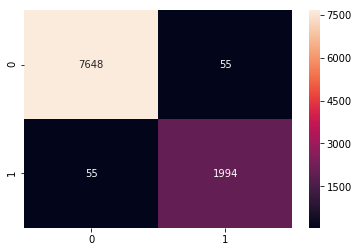

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from sklearn.feature_selection import SelectFromModel,SelectKBest,chi2,mutual_info_classif
from functools import partial

skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
clf = Pipeline([
        ('scale', preprocessing.StandardScaler()),
        ('feature_selection', SelectFromModel(LinearSVC(C=0.0001,penalty="l1",dual=False))),
        ('classification', RandomForestClassifier(random_state=1))
    ])

for train, test in skf.split(fm_train, data_y):
    x_train, y_train = fm_train.iloc[train], data_y.iloc[train]
    clf.fit(x_train, y_train)
    x_test, y_test = fm_train.iloc[test], data_y.iloc[test]
    ac = accuracy_score(y_test,clf.predict(x_test))
    cm = confusion_matrix(y_test, clf.predict(x_test))
    print('Accuracy is: ', ac)
    
x_test, y_test = fm_test, vald_y
ac = accuracy_score(y_test,clf.predict(x_test))
print('Accuracy of test1 is: ', ac)

x_test, y_test = fm_test2, test_y
ac = accuracy_score(y_test,clf.predict(x_test))
print('Accuracy of test2 is: ', ac)
cm = confusion_matrix(y_test, clf.predict(x_test))
sns.heatmap(cm, annot=True, fmt="d")

Part IIb: RF Pipeline with K-Best Mutual Info Feature Selection

Accuracy is:  0.8214725184577523
Accuracy is:  0.9148892534864643
Accuracy is:  0.7850697292863003
Accuracy is:  0.8208572600492207
Accuracy is:  0.8234208367514356
Accuracy is:  0.8894585726004922
Accuracy is:  0.8736669401148482
Accuracy is:  0.7938884331419196
Accuracy is:  0.8060910582444627
Accuracy is:  0.9106849876948319
Accuracy of test1 is:  0.8716697936210132
Accuracy of test2 is:  0.9718006562756357


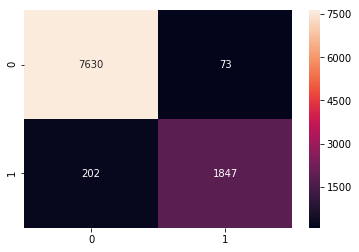

In [28]:
fm_train = pd.DataFrame(stdscaler.fit_transform(fm_train), columns=fm_train.columns)
fm_test = pd.DataFrame(stdscaler.fit_transform(fm_test), columns=fm_train.columns)
fm_test2 = pd.DataFrame(stdscaler.fit_transform(fm_test2), columns=fm_train.columns)

for train, test in skf.split(fm_train, data_y):
    x_train, y_train = fm_train.iloc[train], data_y.iloc[train]
    # find best scored features
    select_feature = SelectKBest(score_func=mutual_info_classif, k=12).fit(x_train,y_train)
    #print('Score list:', select_feature.scores_)
    #print('Feature list:', x_train.columns)
    x_train_2 = select_feature.transform(x_train)
    x_test_2 = select_feature.transform(x_test)
    #random forest classifier with n_estimators=10 (default)
    clf_rf_2 = RandomForestClassifier()      
    clr_rf_2 = clf_rf_2.fit(x_train_2,y_train)
    ac_2 = accuracy_score(y_test,clf_rf_2.predict(x_test_2))
    print('Accuracy is: ',ac_2)
    
x_test, y_test = fm_test, vald_y
x_test = select_feature.transform(x_test)
ac = accuracy_score(y_test,clf_rf_2.predict(x_test))
print('Accuracy of test1 is: ', ac)

x_test, y_test = fm_test2, test_y
x_test = select_feature.transform(x_test)
ac = accuracy_score(y_test,clf_rf_2.predict(x_test))
print('Accuracy of test2 is: ', ac)
cm = confusion_matrix(y_test, clf_rf_2.predict(x_test))
sns.heatmap(cm, annot=True, fmt="d")

%99 accuracy is easily matched with RF methods, however, in the literature we have seen less varianced accuracies with other ML methods. Let's save the dataframes here and search for a better approach with autoML (TPOT), semi-autoML with hyperparameter search. 